<a href="https://colab.research.google.com/github/20hnu/time_series/blob/main/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

In [41]:
import warnings
warnings.filterwarnings('ignore')

In [42]:
df= pd.read_csv("/content/drive/MyDrive/Campus_X_share/ARIMA_code/catfish.csv")

In [43]:
df['Date'] = pd.to_datetime(df['Date'])

In [44]:
df.set_index('Date', inplace=True)

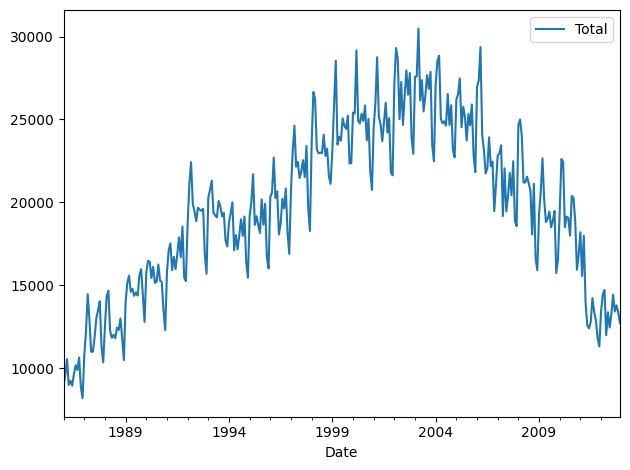

In [45]:
df["Total"].plot(legend=True)
plt.tight_layout()
plt.show()

In [46]:
def test_stationarity(timeseries):
  result = adfuller(timeseries)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])

  if result[1] <= 0.05:
    print("The series is stationary")
  else:
    print("The series is not stationary")

In [47]:
test_stationarity(df["Total"])

ADF Statistic: -1.589903
p-value: 0.488664
The series is not stationary


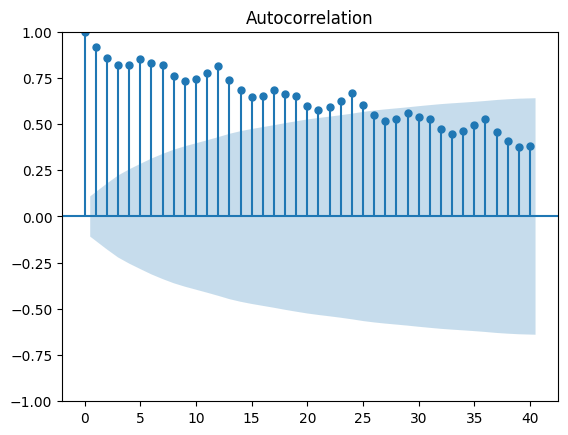

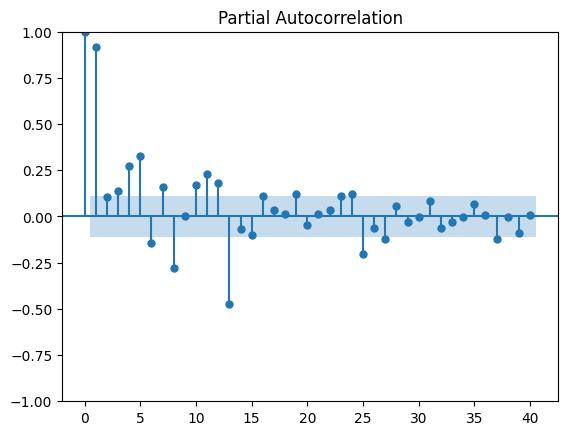

In [48]:
plot_acf(df["Total"], lags=40)
plot_pacf(df["Total"], lags=40)
plt.show()

In [49]:
train_size = int(len(df) * 0.80)
train, test = df[0:train_size], df[train_size:]

In [50]:
start = len(train)
end = len(train) + len(test) -1

In [51]:
model = ARIMA(train["Total"], order=(1,0,1))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Total   No. Observations:                  259
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2318.444
Date:                Sat, 30 Nov 2024   AIC                           4644.888
Time:                        06:00:32   BIC                           4659.115
Sample:                    01-01-1986   HQIC                          4650.608
                         - 07-01-2007                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.016e+04   5432.548      3.711      0.000    9513.198    3.08e+04
ar.L1          0.9963      0.006    177.199      0.000       0.985       1.007
ma.L1         -0.7030      0.046    -15.245      0.000      -0.793      -0.613
sigma2      3.445e+06     20.053   1.72e+05      0.000    3.45e+06    3.45e+06
===================================================================================
Ljung-Box (L1) (Q):                  20.16   Jarque-Bera (JB):                 4.52
Prob(Q):                              0.00   Prob(JB):                         0.10
Heteroskedasticity (H):               1.80   Skew:                             0.32
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.01e+24. Standard errors may be unstable.
"""

In [52]:
print(start)
print(end)

259
323


In [53]:
prediction = model.predict(start=start, end= end, type="levels")
prediction.index = df.index[start:end+1]

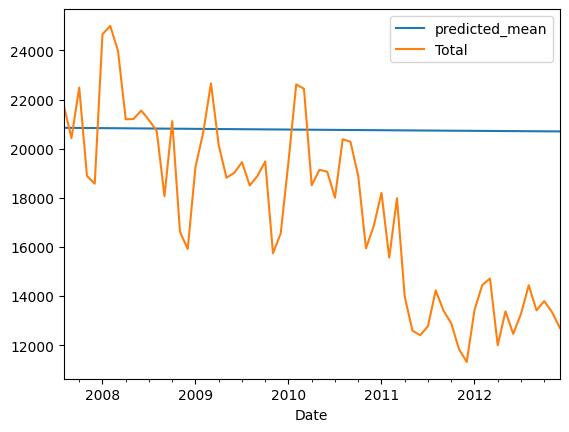

In [54]:
prediction.plot(legend=True)
test["Total"].plot(legend=True)
plt.show()

In [55]:
prediction

,predicted_mean
Date,
2007-08-01,20849.732054
2007-09-01,20847.164879
2007-10-01,20844.607269
2007-11-01,20842.059190
2007-12-01,20839.520606
...,...
2012-08-01,20711.475790
2012-09-01,20709.423798
2012-10-01,20707.379453


In [56]:
mae = mean_absolute_error(prediction,test["Total"])
print(mae)

3844.4995387595254


##GRID SEARCH

In [57]:

def grid_search_for_stationary(series, max_diff_order=2, alpha=0.05):
  adf_result = adfuller(series)
  if adf_result[1] <= alpha:
    print("The series is stationary")
  else:
    for d in range(1, max_diff_order+1):
      differenced_series = series.diff(d).dropna()
      adf_result = adfuller(differenced_series)
      p_value_diff = adf_result[1]

      if p_value_diff < alpha:
        print("Series after {} order differencing is stationary (p-value: {:.4f})".format(d, p_value_diff))
        return differenced_series
  return None


In [58]:
stationary_series = grid_search_for_stationary(df["Total"])

Series after 1 order differencing is stationary (p-value: 0.0004)


In [59]:
def evaluate_arima_model(X, arima_order):
  train_length = int(len(X)* 0.80)
  train_grid, test_grid = X[0:train_length],X[train_length:]
  history = [X for X in train_grid]
  predictions = list()

  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(test_grid[t])

  error = mean_absolute_error(test_grid, predictions)
  return error, predictions

In [60]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse,predictions = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return predictions


In [61]:
%%time
p_values = range(0,3)
d_values = range(0,3)
q_values = range(0,3)
predictions_f=evaluate_models(df['Total'], p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=3450.778
ARIMA(0, 0, 1) RMSE=2172.966
ARIMA(0, 0, 2) RMSE=2179.708
ARIMA(0, 1, 0) RMSE=1507.477
ARIMA(0, 1, 1) RMSE=1570.985
ARIMA(0, 1, 2) RMSE=1436.715
ARIMA(0, 2, 0) RMSE=2365.062
ARIMA(0, 2, 1) RMSE=1514.176
ARIMA(0, 2, 2) RMSE=1583.050
ARIMA(1, 0, 0) RMSE=1482.214
ARIMA(1, 0, 1) RMSE=1570.074
ARIMA(1, 0, 2) RMSE=1444.307
ARIMA(1, 1, 0) RMSE=1515.406
ARIMA(1, 1, 1) RMSE=1464.110
ARIMA(1, 1, 2) RMSE=1440.833
ARIMA(1, 2, 0) RMSE=2119.407
ARIMA(1, 2, 1) RMSE=1517.607
ARIMA(1, 2, 2) RMSE=1495.195
ARIMA(2, 0, 0) RMSE=1494.899
ARIMA(2, 0, 1) RMSE=1470.313
ARIMA(2, 0, 2) RMSE=1443.943
ARIMA(2, 1, 0) RMSE=1474.370
ARIMA(2, 1, 1) RMSE=1420.944
ARIMA(2, 1, 2) RMSE=1468.236
ARIMA(2, 2, 0) RMSE=1978.107
ARIMA(2, 2, 1) RMSE=1479.750
ARIMA(2, 2, 2) RMSE=1450.905
Best ARIMA(2, 1, 1) RMSE=1420.944
CPU times: user 14min 57s, sys: 2.21 s, total: 14min 59s
Wall time: 10min 54s


##Auto ARIMA

In [64]:
%%capture
!pip install pmdarima
from pmdarima import auto_arima

In [66]:
stepwise_fit = auto_arima(train, start_p=0, start_q = 0,d=1, max_p = 40, max_q=40, information_criterion='bic', trace=True, suppress_warnings=True, stepwise=True, seasonal=False)
stepwise_fit.summary()

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=4649.232, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=4649.084, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=4638.067, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=4643.814, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=4607.085, Time=0.96 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : BIC=4602.170, Time=1.83 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : BIC=4649.248, Time=0.36 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : BIC=4583.298, Time=1.47 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : BIC=4612.777, Time=0.74 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : BIC=4559.523, Time=1.83 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : BIC=4568.196, Time=0.87 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : BIC=4564.788, Time=6.59 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : BIC=inf, Time=5.66 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : BIC=4542.279, Time=4.70 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  259
Model:               SARIMAX(4, 1, 3)   Log Likelihood               -2231.495
Date:                Sat, 30 Nov 2024   AIC                           4478.991
Time:                        06:18:04   BIC                           4507.414
Sample:                    01-01-1986   HQIC                          4490.420
                         - 07-01-2007                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0314      0.083    -12.425      0.000      -1.194      -0.869
ar.L2         -0.3176      0.146     -2.171      0.030      -0.604      -0.031
ar.L3         -0.2221      0.135     -1.649      0.099      -0.486       0.042
ar.L4         -0.5288      0.071     -7.495      0.000      -0.667      -0.391
ma.L1          0.9692      0.091     10.632      0.000       0.791       1.148
ma.L2         -0.2428      0.151     -1.608      0.108      -0.539       0.053
ma.L3         -0.6656      0.096     -6.967      0.000      -0.853      -0.478
sigma2      2.131e+06   1.17e-08   1.82e+14      0.000    2.13e+06    2.13e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.73   Jarque-Bera (JB):                 3.49
Prob(Q):                              0.39   Prob(JB):                         0.17
Heteroskedasticity (H):               1.42   Skew:                             0.27
Prob(H) (two-sided):                  0.11   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.88e+30. Standard errors may be unstable.
"""

In [67]:
model_3 = ARIMA(train["Total"],order=(4,1,3))
model_3 = model_3.fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Total   No. Observations:                  259
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -2231.495
Date:                Sat, 30 Nov 2024   AIC                           4478.991
Time:                        06:18:19   BIC                           4507.414
Sample:                    01-01-1986   HQIC                          4490.420
                         - 07-01-2007                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0314      0.083    -12.425      0.000      -1.194      -0.869
ar.L2         -0.3176      0.146     -2.171      0.030      -0.604      -0.031
ar.L3         -0.2221      0.135     -1.649      0.099      -0.486       0.042
ar.L4         -0.5288      0.071     -7.495      0.000      -0.667      -0.391
ma.L1          0.9692      0.091     10.632      0.000       0.791       1.148
ma.L2         -0.2428      0.151     -1.608      0.108      -0.539       0.053
ma.L3         -0.6656      0.096     -6.967      0.000      -0.853      -0.478
sigma2      2.131e+06   1.17e-08   1.82e+14      0.000    2.13e+06    2.13e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.73   Jarque-Bera (JB):                 3.49
Prob(Q):                              0.39   Prob(JB):                         0.17
Heteroskedasticity (H):               1.42   Skew:                             0.27
Prob(H) (two-sided):                  0.11   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.88e+30. Standard errors may be unstable.
"""

In [68]:
pred_3 =model_3.predict(start=start, end=end, type="levels")

In [69]:
pred_3

,predicted_mean
2007-08-01,22583.810373
2007-09-01,20998.779846
2007-10-01,22474.343783
2007-11-01,20475.823737
2007-12-01,21254.019754
...,...
2012-08-01,21961.747322
2012-09-01,20463.197991
2012-10-01,22195.552860
2012-11-01,20690.921518


In [70]:
pred_3.index=df.index[start:end+1]

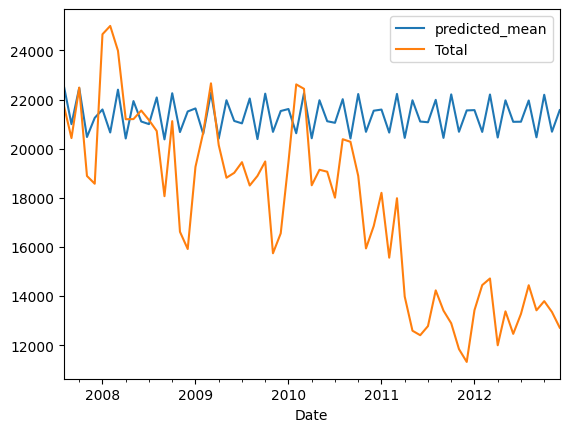

In [71]:
pred_3.plot(legend=True)
test["Total"].plot(legend=True)
plt.show()

In [72]:
rmse = sqrt(mean_squared_error(pred_3,test["Total"]))
print(rmse)

5182.483862910423


In [73]:
test["Total"].mean()

17581.33846153846

In [76]:
model_future = ARIMA(df["Total"], order=(4,1,3))
model_future = model_future.fit()

In [79]:
df.tail()

,Total
Date,
2012-08-01,14442
2012-09-01,13422
2012-10-01,13795
2012-11-01,13352
2012-12-01,12716


In [78]:
index_future = pd.date_range(start="2012-12-01", end="2013-08-01", freq='M')
index_future

DatetimeIndex(['2012-12-31', '2013-01-31', '2013-02-28', '2013-03-31',
               '2013-04-30', '2013-05-31', '2013-06-30', '2013-07-31'],
              dtype='datetime64[ns]', freq='ME')

In [82]:
forcast_future = model_future.predict(start=len(df), end=len(df)+7, type="level")

In [83]:
forcast_future

,predicted_mean
2013-01-01,12890.563582
2013-02-01,12496.440018
2013-03-01,14025.148975
2013-04-01,12807.938059
2013-05-01,13561.972894
2013-06-01,13066.978659
2013-07-01,12820.922144
2013-08-01,13709.707628


In [85]:
forcast_future.index = index_future

In [86]:
forcast_future

,predicted_mean
2012-12-31,12890.563582
2013-01-31,12496.440018
2013-02-28,14025.148975
2013-03-31,12807.938059
2013-04-30,13561.972894
2013-05-31,13066.978659
2013-06-30,12820.922144
2013-07-31,13709.707628


In [87]:
len(df)

324

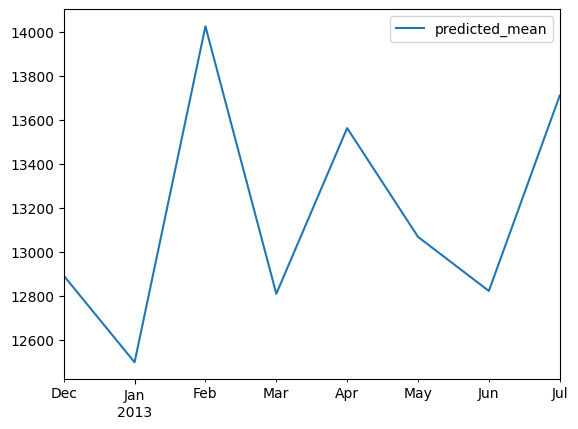

In [88]:
forcast_future.plot(legend=True)
plt.show()

In [91]:
df_final =  pd.DataFrame({'Date':forcast_future.index, "Total":forcast_future.values})

In [92]:
df_final["Date"]=pd.to_datetime(df_final["Date"])

In [93]:
df_final.set_index("Date", inplace=True)

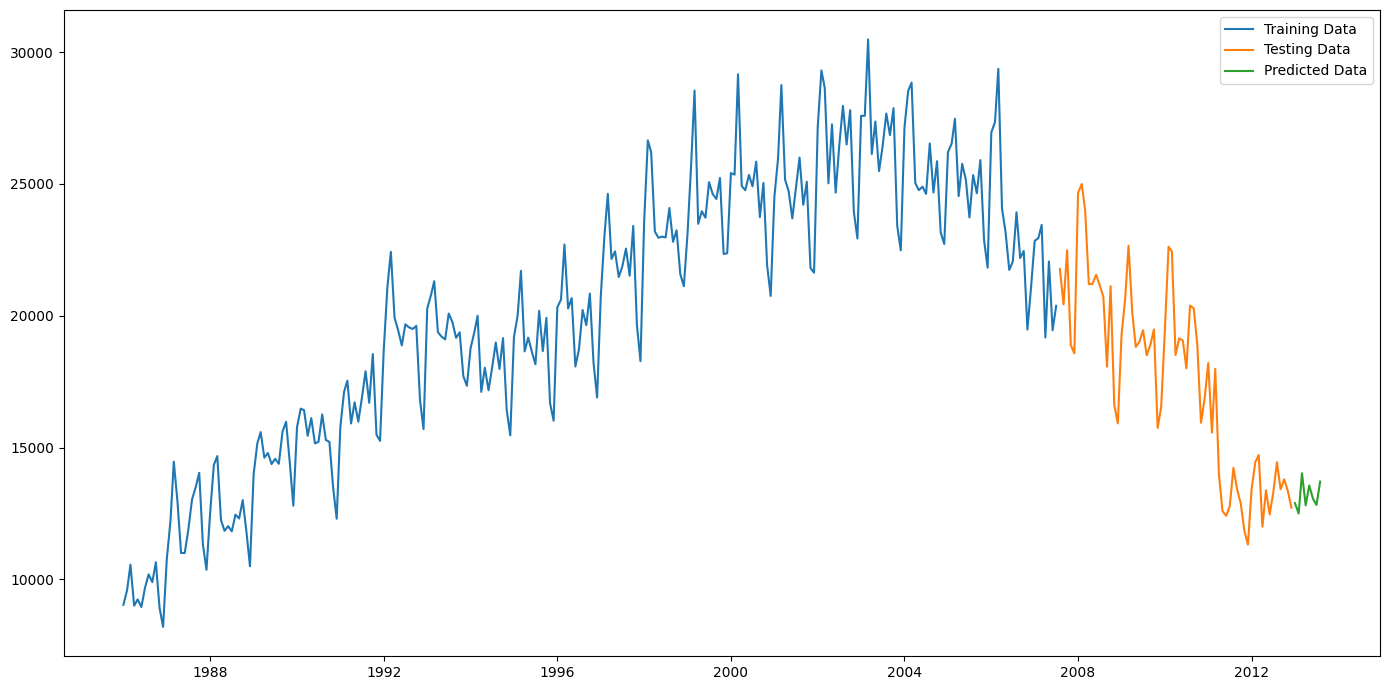

In [94]:
plt.figure(figsize=(14,7))
plt.plot(train.index, train["Total"],label='Training Data')
plt.plot(test.index, test["Total"], label='Testing Data')
plt.plot(df_final.index, df_final["Total"], label='Predicted Data')
plt.legend()
plt.tight_layout()
plt.show()

##Hack: Difference the series and then apply auto arima

In [95]:
new_df = df.copy()

In [97]:
cat_df = df.diff().dropna()

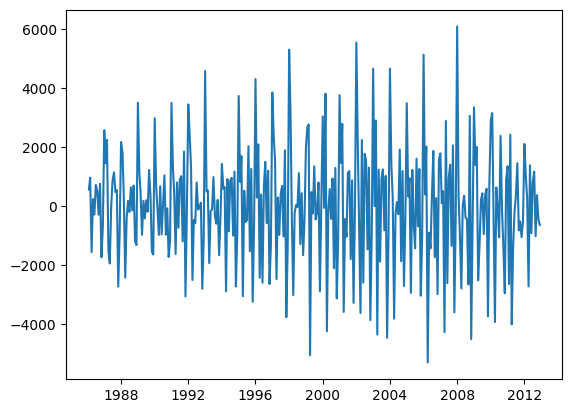

In [99]:
plt.plot(cat_df)

In [100]:
train_size = int(len(cat_df) * 0.80)
train_cat, test_cat = cat_df[0:train_size], cat_df[train_size:]

In [102]:
stepwise_fit_2 = auto_arima(train_cat, start_p=0, start_q = 0,d=0, max_p = 40, max_q=40, information_criterion='aic', trace=True, suppress_warnings=True, stepwise=True)
stepwise_fit_2.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4642.127, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4637.839, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4620.778, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4640.259, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4588.437, Time=0.82 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4579.774, Time=1.63 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4633.567, Time=0.21 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=4560.916, Time=0.83 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4593.534, Time=0.40 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=4528.869, Time=1.89 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=4542.096, Time=0.37 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=4530.515, Time=2.03 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=4

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  258
Model:              SARIMAX(12, 0, 9)   Log Likelihood               -2128.360
Date:                Sat, 30 Nov 2024   AIC                           4300.721
Time:                        06:48:40   BIC                           4378.886
Sample:                    02-01-1986   HQIC                          4332.151
                         - 07-01-2007                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3165      0.235     -1.348      0.178      -0.777       0.144
ar.L2         -0.4110      0.128     -3.220      0.001      -0.661      -0.161
ar.L3         -0.7986      0.213     -3.741      0.000      -1.217      -0.380
ar.L4         -0.4119      0.154     -2.678      0.007      -0.713      -0.110
ar.L5         -0.3195      0.125     -2.555      0.011      -0.565      -0.074
ar.L6         -0.8951      0.143     -6.275      0.000      -1.175      -0.616
ar.L7         -0.2991      0.237     -1.263      0.206      -0.763       0.165
ar.L8         -0.4088      0.128     -3.183      0.001      -0.661      -0.157
ar.L9         -0.7899      0.211     -3.741      0.000      -1.204      -0.376
ar.L10        -0.3944      0.143     -2.765      0.006      -0.674      -0.115
ar.L11        -0.2931      0.115     -2.559      0.010      -0.518      -0.069
ar.L12         0.1018      0.130      0.783      0.434      -0.153       0.357
ma.L1         -0.1329      0.237     -0.561      0.575      -0.597       0.332
ma.L2          0.1288      0.191      0.673      0.501      -0.246       0.504
ma.L3          0.6270      0.186      3.364      0.001       0.262       0.992
ma.L4          0.0484      0.093      0.521      0.602      -0.134       0.230
ma.L5          0.0612      0.092      0.667      0.505      -0.119       0.241
ma.L6          0.7685      0.090      8.493      0.000       0.591       0.946
ma.L7         -0.1695      0.190     -0.890      0.373      -0.543       0.204
ma.L8          0.1801      0.185      0.973      0.331      -0.183       0.543
ma.L9          0.5647      0.188      3.004      0.003       0.196       0.933
sigma2      9.391e+05   1.24e+05      7.560      0.000    6.96e+05    1.18e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.98
Prob(Q):                              0.95   Prob(JB):                         0.61
Heteroskedasticity (H):               1.50   Skew:                             0.10
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.6e+14. Standard errors may be unstable.
"""

In [103]:
model_4 = ARIMA(train_cat["Total"],order=(12,0,9))
model_4 = model_4.fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Total   No. Observations:                  258
Model:                ARIMA(12, 0, 9)   Log Likelihood               -2128.291
Date:                Sat, 30 Nov 2024   AIC                           4302.582
Time:                        06:49:16   BIC                           4384.300
Sample:                    02-01-1986   HQIC                          4335.442
                         - 07-01-2007                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.9699     36.744      1.197      0.231     -28.047     115.987
ar.L1         -0.3807      0.172     -2.207      0.027      -0.719      -0.043
ar.L2         -0.4413      0.123     -3.589      0.000      -0.682      -0.200
ar.L3         -0.7886      0.171     -4.625      0.000      -1.123      -0.454
ar.L4         -0.4428      0.127     -3.474      0.001      -0.693      -0.193
ar.L5         -0.3803      0.122     -3.113      0.002      -0.620      -0.141
ar.L6         -0.8630      0.129     -6.677      0.000      -1.116      -0.610
ar.L7         -0.3665      0.176     -2.084      0.037      -0.711      -0.022
ar.L8         -0.4479      0.128     -3.512      0.000      -0.698      -0.198
ar.L9         -0.7991      0.172     -4.638      0.000      -1.137      -0.461
ar.L10        -0.4348      0.119     -3.666      0.000      -0.667      -0.202
ar.L11        -0.3586      0.114     -3.144      0.002      -0.582      -0.135
ar.L12         0.1301      0.122      1.069      0.285      -0.108       0.369
ma.L1         -0.0760      0.171     -0.444      0.657      -0.411       0.259
ma.L2          0.0664      0.143      0.466      0.642      -0.213       0.346
ma.L3          0.6160      0.130      4.729      0.000       0.361       0.871
ma.L4          0.0782      0.077      1.010      0.313      -0.074       0.230
ma.L5          0.0990      0.074      1.339      0.181      -0.046       0.244
ma.L6          0.7673      0.064     11.982      0.000       0.642       0.893
ma.L7         -0.0773      0.139     -0.557      0.578      -0.350       0.195
ma.L8          0.1622      0.146      1.112      0.266      -0.124       0.448
ma.L9          0.6684      0.153      4.371      0.000       0.369       0.968
sigma2      9.332e+05      0.000   3.23e+09      0.000    9.33e+05    9.33e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.76
Prob(Q):                              0.93   Prob(JB):                         0.68
Heteroskedasticity (H):               1.64   Skew:                             0.09
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.29e+25. Standard errors may be unstable.
"""

In [104]:
pred_4 = model_4.predict(start=start, end=end, type="levels")
rmse = sqrt(mean_squared_error(pred_4,test_cat["Total"]))
print(rmse)
pred_4

3089.996152711828


,predicted_mean
2007-09-01,-1543.816230
2007-10-01,521.762179
2007-11-01,-3118.360244
2007-12-01,964.167460
2008-01-01,3464.700116
...,...
2012-09-01,-1356.195282
2012-10-01,147.110341
2012-11-01,-3014.612203
2012-12-01,1928.868101
